In [1]:
#Tutustutaan jalkapallovedonlyöntistrategiaan mikä perustuu Pinnacle vedonlyöntisivuston antamiin kertoimiin. Idea on
#yksinkertainen, katsotaan Pinnaclen antama kerroin kotijoukkueen voitolle ja etsitään se sama toiselta vedonlyöntisivulta
#ja mikäli tämä toisella vedonlyöntisivustolla oleva kerroin on isompi, lyödään siihen. 

#Tämä perustuu siihen ideaan, että
#Pinnacle on ns. sharp bookmaker eli Pinnaclen käyttämät mallit kertoimien määrittelyssä ovat laadukkaita ja tarkkoja. Sitten 
#on olemassa myös ns. soft bookmakereita eli Pinnaclen vastakohtia, jotka eivät käytä niin tarkkoja malleja eikä ne ole niin 
#laadukkaita. Pyritään siis etsimään pehmeiltä vedonlyöntisivuilta ylikertoimia ja lyödään niihin. Tähän käytetään Pinnaclen
#antamia tarkkoja kertoimia. 

In [49]:
import numpy as np
import pandas as pd
#Bettools moduulin avulla voidaan generoida aikaisemmat tulokset ja niiden pelien kertoimet
from bettools import get_data, generate_seasons

In [50]:
#Aloitetaan analysoimalla vedonlyöntistrategiaa Valioliigan 23-24 kaudesta, joka on datasetissä nimellä E0
valioliiga = ['E0']
kaudet = generate_seasons(2023, 2024)
#Kaivetaan näillä tiedoilla tuon kauden data get_data työkalulla
data = get_data(kaudet, valioliiga)
data = pd.concat(data)

In [51]:
#Katsotaan miltä näyttää
print(data)

    Div       Date          HomeTeam       AwayTeam  FTHG  FTAG   PSH    PSD  \
0    E0 2023-08-11           Burnley       Man City     0     3  8.58   5.51   
1    E0 2023-08-12           Arsenal  Nott'm Forest     2     1  1.18   7.86   
2    E0 2023-08-12       Bournemouth       West Ham     1     1  2.70   3.47   
3    E0 2023-08-12          Brighton          Luton     4     1  1.33   5.65   
4    E0 2023-08-12           Everton         Fulham     0     1  2.27   3.45   
..   ..        ...               ...            ...   ...   ...   ...    ...   
375  E0 2024-05-19    Crystal Palace    Aston Villa     5     0  1.83   4.37   
376  E0 2024-05-19         Liverpool         Wolves     2     0  1.16   9.27   
377  E0 2024-05-19             Luton         Fulham     2     4  2.93   3.92   
378  E0 2024-05-19          Man City       West Ham     3     1  1.09  13.11   
379  E0 2024-05-19  Sheffield United      Tottenham     0     3  7.16   6.00   

       PSA  home_max_odds  away_max_odd

In [52]:
#Mihin me tässä haluamme kiinnittää huomiota on PSH (Pinnaclen antama kerroin kotijoukkuueen voitolle) ja home_max_odds, joka
#kertoo, että mikä on korkein kerroin minkä on voinut saada joltain soft-vedonlyöntisivulta. Lisäksi myös FTGH ja FTAG kertoo
#että miten pelissä tuli varsinaisella pa maaleja, josta voidaan päätellä voittaja niin jätetään ne. Poistetaan turhat sarakkeet.

In [53]:
turhat_sarakkeet = ['Div', 'HomeTeam', 'AwayTeam', 'PSD', 'PSA', 'away_max_odds', 'draw_max_odds']
data = data.drop(columns=turhat_sarakkeet)

In [54]:
#Katsotaan miltä nyt näyttää
print(data)

          Date  FTHG  FTAG   PSH  home_max_odds
0   2023-08-11     0     3  8.58           9.50
1   2023-08-12     2     1  1.18           1.20
2   2023-08-12     1     1  2.70           2.70
3   2023-08-12     4     1  1.33           1.35
4   2023-08-12     0     1  2.27           2.27
..         ...   ...   ...   ...            ...
375 2024-05-19     5     0  1.83           1.88
376 2024-05-19     2     0  1.16           1.17
377 2024-05-19     2     4  2.93           2.93
378 2024-05-19     3     1  1.09           1.11
379 2024-05-19     0     3  7.16           7.50

[380 rows x 5 columns]


In [55]:
#Näyttää hyvältä ja nyt luodaan uusi DataFrame, joka koostuu lyödyistä vedoista eli niistä kerroista kun home_max_odds > PSH

In [56]:
lyodyt_vedot = data[data['home_max_odds']>data['PSH']].copy()
lyodyt_vedot.reset_index(inplace=True, drop=True)
lyodyt_vedot.sort_values('Date') #Asetetaan ottelut aikajärjestykseen

#Seuraavaksi luodaan lyodyt_vedot DataFrameen uusi sarake, johon kerätään voitot ja häviöt. np.where on työkalu, joka ottaa 
#parametrit np.where(condition, x, y) eli mikäli condition täyttyy palautetetaan x ja mikäli ei niin palautetaan y
#tässä lyodyt_vedot['FTHG']>lyodyt_vedot['FTAG'] on condition eli FullTimeHomeGoals täytyy olla suurempi kuin FullTimeAwayGoals
#, x on lyodyt_vedot['home_max_odds']-1 eli mikäli veto osuu niin voitto on (kerroin - 1), koska lyötyä panosta ei lasketa 
#voitoksi. Ja y on -1 mikä tarkoittaa, että panos häviää.
lyodyt_vedot['Voitot/Häviöt'] = np.where(lyodyt_vedot['FTHG']>lyodyt_vedot['FTAG'], lyodyt_vedot['home_max_odds']-1, -1)
lyodyt_vedot.reset_index(inplace=True, drop=True)

In [57]:
#Katsotaan miltä DataFramen ensimmäiset 10 riviä näyttävät
print(lyodyt_vedot.head(10))

        Date  FTHG  FTAG   PSH  home_max_odds  Voitot/Häviöt
0 2023-08-11     0     3  8.58           9.50          -1.00
1 2023-08-12     2     1  1.18           1.20           0.20
2 2023-08-12     4     1  1.33           1.35           0.35
3 2023-08-13     2     2  2.76           2.85          -1.00
4 2023-08-14     1     0  1.32           1.33           0.33
5 2023-08-19     3     1  1.23           1.25           0.25
6 2023-08-19     2     0  2.85           2.88           1.88
7 2023-08-20     3     1  3.68           3.75           2.75
8 2023-08-21     0     1  5.73           6.00          -1.00
9 2023-08-25     3     0  1.30           1.31           0.31


Text(0, 0.5, 'Kumuloituneet voitot/häviöt')

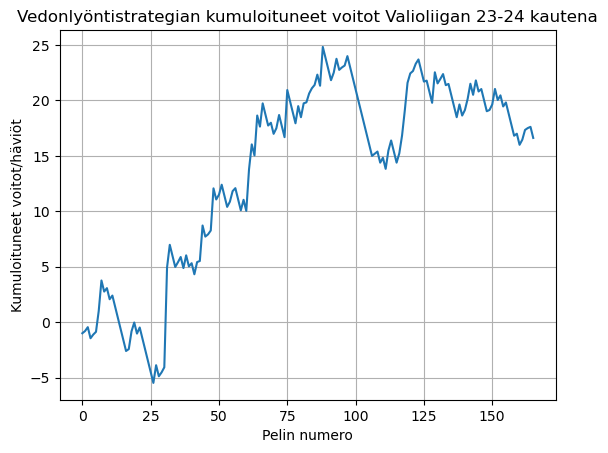

In [58]:
#Seuraavaksi visualisoidaan miltä koko sarake näyttää eli luodaan cumulative sum, jossa käyrä kertoo mihin suuntaan voitot ja 
#häviöt menevät
import matplotlib.pyplot as plt


lyodyt_vedot['Voitot/Häviöt'].cumsum().plot() #Lasketaan cumulative sum ja näytetään se kuvaajalla plot() komennolla
plt.grid(True) #Halutaan ruudut
plt.title('Vedonlyöntistrategian kumuloituneet voitot Valioliigan 23-24 kautena')
plt.xlabel('Pelin numero') #Annetaan x-akselin nimi
plt.ylabel('Kumuloituneet voitot/häviöt')

In [59]:
#Eli mitä tämä kuvaaja kertoo on se, että Voitot/Häviöt sarakkeen yhteenlaskettu summa on noin 16 eli jos olisi seurannut tätä
#vedonlyöntistrategiaa niin olisi 16-kertaistanut rahansa. 

In [48]:
#Mitä konkreettista tästä jäi käteen

#Kannattaa lyödessä vetoa tarkistaa, että minkälaista kerrointa Pinnacle antaa kohteelle (jota lyöt toisella (pehmeällä)
#vedonlyöntisivustolla ja jos olet lyömässä kerrointa mikä on huonompi kuin Pinnaclen antama niin ei kannata lyödä siihen, koska
#se on todennäköisesti alikerroin ja pitkällä tähtäimellä siitä jää häviölle.